In [132]:
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
import seaborn as sns

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(789)

In [ ]:
def np_sig(x): return 1.0/(1.0+np.exp(-x))
def d_np_sig(x): return np_sig(x) * (1.0 - np_sig(x))

class FNN_numpy():

    def __init__(self,inc,outc):
        self.w = np.random.randn(inc,outc)
        self.m,self.v = np.zeros_like(self.w),np.zeros_like(self.w)

    def feedforward(self,input):
        self.input = input
        self.layer = self.input.dot(self.w)
        self.layerA = np_sig(self.layer)
        return self.layerA

    def backprop(self,grad):
        grad_part_1 = grad
        grad_part_2 = d_np_sig(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = grad_part_3.T.dot(grad_middle)
        grad_pass = grad_middle.dot(self.w.T)

        self.m = self.m * beta1 + (1.0-beta1) * grad
        self.v = self.v * beta2 + (1.0-beta2) * grad ** 2
        m_hat,v_hat = self.m/(1.-beta1),self.v/(1.-beta2)
        adam_mid = learning_rate / (np.sqrt(v_hat) + adam_e) * m_hat
        self.w = self.w - adam_mid
        return grad_pass

class whitening_layer():

    def __init__(self):
        self.moving_sigma = 0
        self.moving_mean = 0

    def feedforward(self,input):
        self.input = input
        self.mean = np.mean(input,axis=0)
        self.sigma = (input - self.mean).T.dot(input - self.mean) / input.shape[1]
        self.eigenval,self.eigvector = np.linalg.eigh(self.sigma)
        self.U = self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval)))
        self.whiten = (input - self.mean).dot(self.U)
        self.zca = self.whiten.dot(self.eigvector)
        return self.zca

    def backprop(self,grad):
        dwhiten = grad.dot(self.eigvector.T)
        dU = (self.input-self.mean).T.dot(dwhiten)
        deigenval = self.eigvector.T.dot(dU).dot(np.diag(-0.5 * 1/(self.eigenval ** 1.5)))
        deigvector = self.whiten.T.dot(grad) + dU.dot(np.diag(1. / np.sqrt(self.eigenval)).T)
        
        shape_eig = self.eigenval.shape[0]
        Iden = np.eye(shape_eig)
        E = np.ones((shape_eig,1)).dot(np.expand_dims(self.eigenval.T,0))-np.expand_dims(self.eigenval,1).dot(np.ones((1,shape_eig)))
        F = 1.0/(E+Iden) - Iden
        deigenval_zero = np.eye(deigenval.shape[0]) * deigenval
        dsigma = self.eigvector.dot( F.T * (self.eigvector.dot(deigvector))+deigenval_zero).dot(self.eigvector.T)     
        
        symm_sigma = 0.5 * (dsigma.T + dsigma)
        dmean = -np.sum(dwhiten,0).dot(self.U.T) + (-2/shape_eig) * np.mean(self.input - self.mean,0).dot(symm_sigma)
        
        dInput = dwhiten.dot(self.U.T) + (2/shape_eig) * (self.input - self.mean).dot(symm_sigma) + 1/shape_eig * dmean
        return dInput

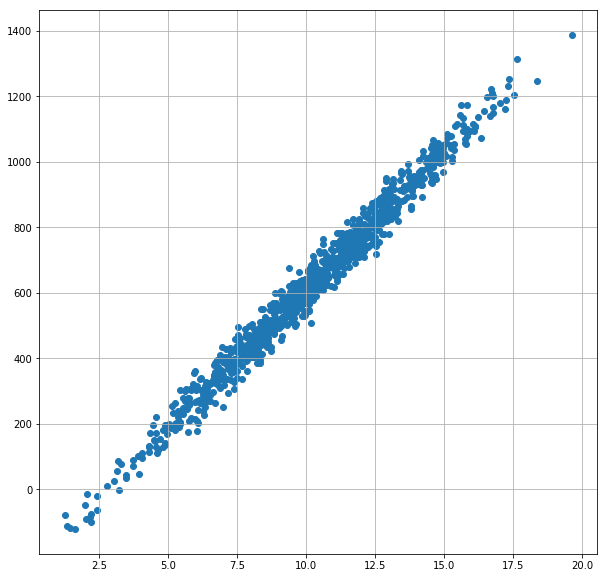

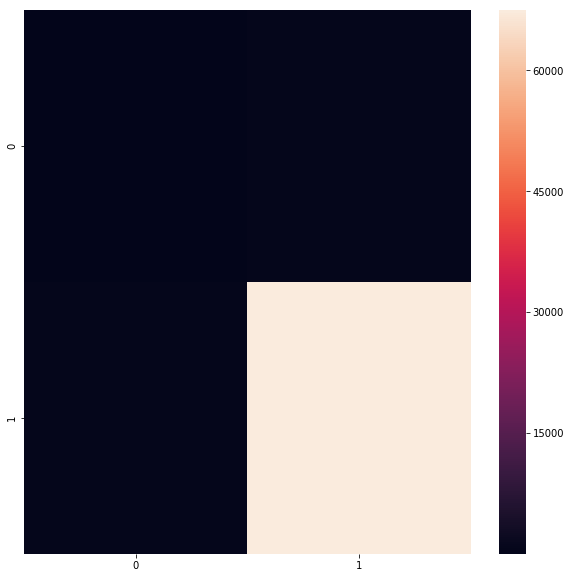

In [281]:
# hyper
batch_size = 100
learning_rate = 0.0001
beta1,beta2,adam_e = 0.9,0.999,1e-8
white_e = 10e-5

# data 
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=1, noise=12.,random_state =9) 
y = y + 200
sample_data = 3*np.hstack((X,np.expand_dims(y,1))) + 10

# show
%matplotlib inline  
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(sample_data[:,0],sample_data[:,1])
plt.show()

# covariance mat
plt.figure(figsize=(10, 10))
sns.heatmap(np.cov(sample_data.T))
plt.show()

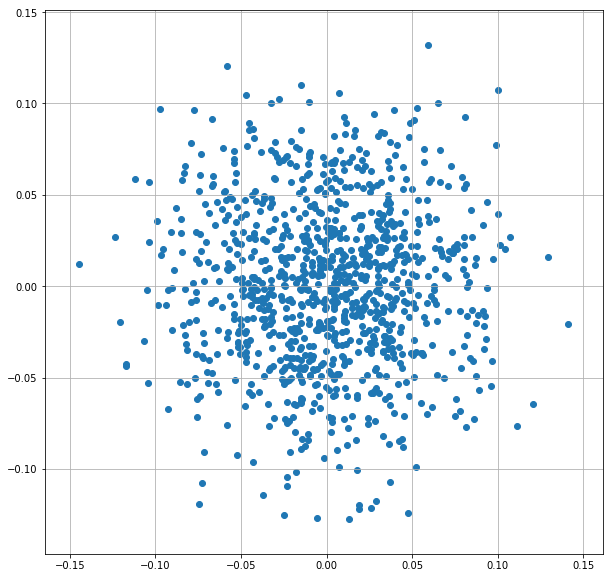

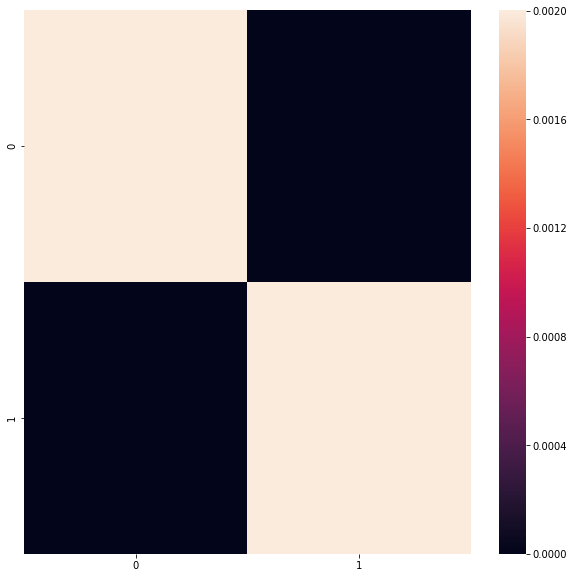

In [282]:
# class
wh_l = whitening_layer()
whiten_data = wh_l.feedforward(sample_data)

plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(whiten_data[:,0],whiten_data[:,1])
plt.show()

# covariance mat
plt.figure(figsize=(10, 10))
sns.heatmap(np.cov(whiten_data.T))
plt.show()

In [283]:
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    EPS = 10e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(d + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), E.T)

    X_white = np.dot(X, W)

    return X_white

(2,)


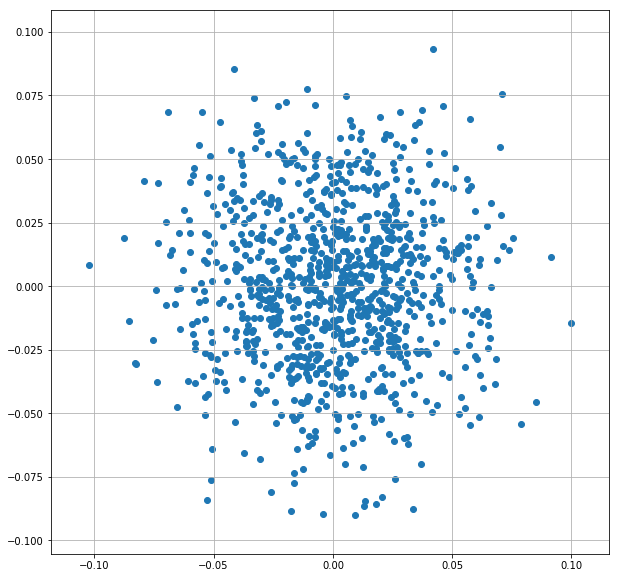

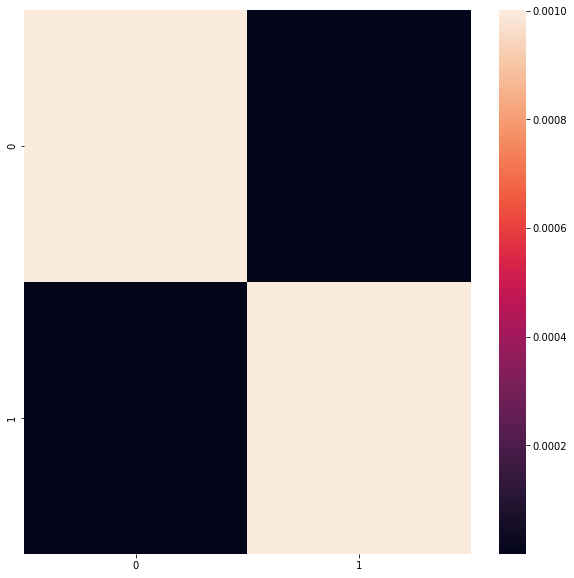

In [284]:
print(np.mean(sample_data,0).shape)
centered_data = sample_data - np.mean(sample_data,0)
temp = zca_whiten(centered_data)
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(temp[:,0],temp[:,1])
plt.show()

# covariance mat
plt.figure(figsize=(10, 10))
sns.heatmap(np.cov(temp.T))
plt.show()